In [1]:
!git clone https://github.com/karoldvl/ESC-50.git


fatal: destination path 'ESC-50' already exists and is not an empty directory.


In [2]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import soundfile as sf
import os
import pandas as pd
import librosa
import librosa.display

In [3]:

# List audio files
audio_path = "ESC-50/audio"
print("Number of audio files:", len(os.listdir(audio_path)))

# Print a few sample files
print(os.listdir(audio_path)[:5])


Number of audio files: 2000
['2-166644-A-2.wav', '4-171207-A-12.wav', '1-28135-B-11.wav', '4-167077-B-20.wav', '1-67230-A-29.wav']


**Load Metadata**

In [4]:


meta = pd.read_csv("ESC-50/meta/esc50.csv")
esc10 = meta[meta['esc10'] == True]  # Filter only ESC-10
esc10 = esc10.reset_index(drop=True)
esc10.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-110389-A-0.wav,1,0,dog,True,110389,A
2,1-116765-A-41.wav,1,41,chainsaw,True,116765,A
3,1-17150-A-12.wav,1,12,crackling_fire,True,17150,A
4,1-172649-A-40.wav,1,40,helicopter,True,172649,A


**Load a Sample Audio File**

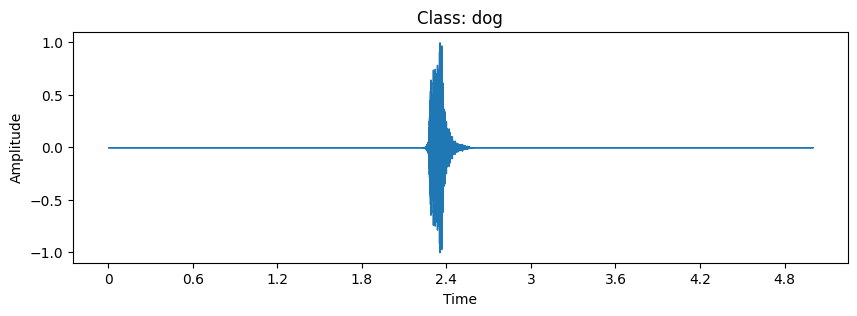

In [5]:

file_path = os.path.join(audio_path, esc10.loc[0, 'filename'])
wave, sr = librosa.load(file_path, sr=None)

# Plot the waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(wave, sr=sr)
plt.title(f"Class: {esc10.loc[0, 'category']}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

**Hyper‑parameters**

In [6]:
SR              = 22050
DURATION        = 5
N_MELS          = 128
HOP_LEN         = 512
BATCH_SIZE      = 64
EPOCHS          = 50
LEARNING_RATE   = 3e-4

**Audio → Mel Spectrogram**

In [7]:
# Add data augmentation to training
def wav_to_mel(filepath, augment=False):
    y, sr = sf.read(filepath)
    if sr != SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=SR)

    # Data augmentation
    if augment:
        if np.random.random() > 0.5:
            y = y * np.random.uniform(0.8, 1.2)  # Random gain
        if np.random.random() > 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))

    max_len = SR * DURATION
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]

    mel = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=N_MELS, hop_length=HOP_LEN)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.astype(np.float32)

In [8]:
# Modify dataset class to use augmentation
class ESCDataset(Dataset):
    def __init__(self, df, root):
        self.df = df
        self.root = root
        # Create label to index mapping from the dataframe
        self.label2idx = {c: i for i, c in enumerate(sorted(self.df['category'].unique()))}


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_path = os.path.join(self.root, row['filename'])
        mel = wav_to_mel(wav_path, augment=True)  # Enable augmentation for training
        mel = torch.tensor(mel).unsqueeze(0)
        label = torch.tensor(self.label2idx[row['category']])
        return mel, label

In [9]:
train_df = esc10[esc10.fold <= 4]
test_df  = esc10[esc10.fold == 5]

train_ds = ESCDataset(train_df,audio_path)
test_ds  = ESCDataset(test_df,audio_path)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)


**CNN Model**

In [10]:
class AudioCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,3), (2,3)),

            nn.AdaptiveAvgPool2d((1,1))
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [11]:
model = AudioCNN(n_classes=len(train_ds.label2idx))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


**Training Loop**

In [12]:
from tqdm.auto import tqdm
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# New: Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

def train_epoch(loader):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for mel, lbl in tqdm(loader, desc="Training"):
        mel, lbl = mel.to(device), lbl.to(device)

        # Forward + backward
        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * mel.size(0)
        running_acc += (outputs.argmax(1) == lbl).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)

    return epoch_loss, epoch_acc

def eval_epoch(loader):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for mel, lbl in tqdm(loader, desc="Validation"):
            mel, lbl = mel.to(device), lbl.to(device)
            outputs = model(mel)
            loss = criterion(outputs, lbl)

            running_loss += loss.item() * mel.size(0)
            running_acc += (outputs.argmax(1) == lbl).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)

    return epoch_loss, epoch_acc

# Training loop with early stopping
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
patience = 5
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(test_loader)

    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch stats
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        # Save best model
        torch.save(model.state_dict(), "best_esc10_model.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} - no improvement for {patience} epochs")
            break

# Load best model
model.load_state_dict(torch.load("best_esc10_model.pth"))
print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 2.1567 | Train Acc: 0.1875 | Val Loss: 2.2584 | Val Acc: 0.1500 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
if w.is_alive():  
       ^^  ^ ^ ^ ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^  
    File "/usr/lib/p

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 1.9076 | Train Acc: 0.3438 | Val Loss: 2.1790 | Val Acc: 0.2000 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():^^
^ ^ ^ ^ ^ ^  ^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^Exception ignored in:     ^assert self._parent_pid == os.getpid(), 'can only test a child process'<function

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    ^^self._shutdown_workers()^
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>    ^
^Traceback (most recent call last):
if w.is_alive():Exception ignored in: ^
  File "/usr/local/lib/python3.11/dist-packages/torc

Epoch 03 | Train Loss: 1.8006 | Train Acc: 0.4031 | Val Loss: 2.0739 | Val Acc: 0.2875 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
    self._shutdown_workers()Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torc

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 1.6809 | Train Acc: 0.4750 | Val Loss: 1.9673 | Val Acc: 0.4000 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
^ ^ ^^  ^ ^^ ^ Exception ignored

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()
  
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
    ^ ^^ ^ ^ Exception ignored in: Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
^
Traceback (most r

Epoch 05 | Train Loss: 1.6137 | Train Acc: 0.4906 | Val Loss: 1.8304 | Val Acc: 0.4375 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>^
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
   Exception ignored in:   <function _Mul

Epoch 06 | Train Loss: 1.5000 | Train Acc: 0.5344 | Val Loss: 1.6762 | Val Acc: 0.5125 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
               ^^^^^^^^^^ ^^
^  File "/us

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 1.3929 | Train Acc: 0.6250 | Val Loss: 1.5146 | Val Acc: 0.5750 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.p

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
         ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
 ^^ ^ Exception ignored in:   ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>  ^^^

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data

Epoch 08 | Train Loss: 1.3626 | Train Acc: 0.5719 | Val Loss: 1.4165 | Val Acc: 0.6125 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
         if w.is_alive(): 
 ^ ^^^Exception ignored in:   ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>  ^
Traceback (most recent call last):
 ^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 1.2918 | Train Acc: 0.5938 | Val Loss: 1.3381 | Val Acc: 0.5500 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

 Exception ignored in:   <function _MultiPr

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():  
         Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>^^ ^
^Exception ignored in: ^Traceback (most recent call last):
^<function _MultiProcessingDataLoaderIter.__del__ at

Epoch 10 | Train Loss: 1.2278 | Train Acc: 0.6156 | Val Loss: 1.3070 | Val Acc: 0.5750 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():  
    ^ ^ ^ ^ ^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

  File "/usr/lib/python

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
            ^ ^^^^^^^^Exception ignore

Epoch 11 | Train Loss: 1.1693 | Train Acc: 0.6188 | Val Loss: 1.1519 | Val Acc: 0.5875 | LR: 3.00e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()
    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  F

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
   ^ ^   ^^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Epoch 12 | Train Loss: 1.1580 | Train Acc: 0.6281 | Val Loss: 1.1376 | Val Acc: 0.5750 | LR: 1.50e-04


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

         ^   ^ ^ ^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():self._shutdown_workers()
 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
          ^ ^^^^^Exception ignored in: ^^^^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b23f33e71a0>^
^^^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils

Epoch 13 | Train Loss: 1.0527 | Train Acc: 0.6937 | Val Loss: 1.1136 | Val Acc: 0.6125 | LR: 1.50e-04
Early stopping at epoch 13 - no improvement for 5 epochs
Training complete. Best validation accuracy: 0.6125


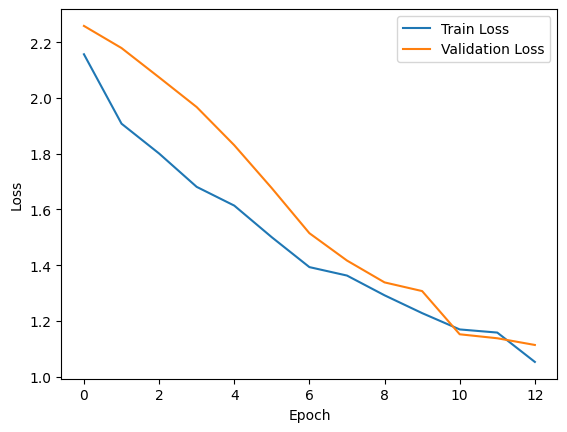

In [13]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

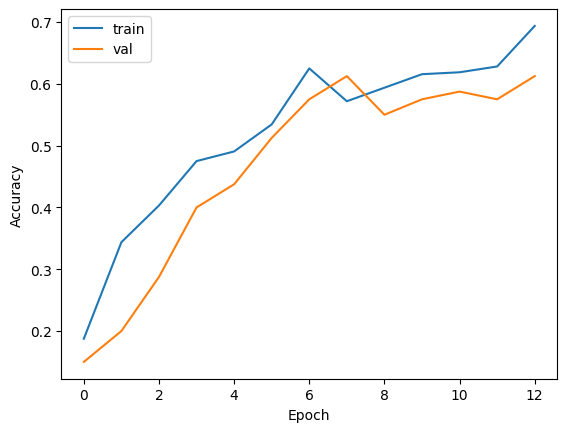

In [14]:
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"],   label="val")
plt.ylabel("Accuracy"); plt.xlabel("Epoch"); plt.legend(); plt.show()


In [15]:
def predict(filepath):
    model.eval()
    mel = wav_to_mel(filepath)
    mel = torch.tensor(mel).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(mel)
    idx = out.argmax(1).item()
    print("Predicted class:", train_ds.df.category.unique()[idx])

predict(os.path.join(audio_path, test_df.iloc[0].filename))


Predicted class: helicopter


In [16]:
!apt-get -qq install ffmpeg  # adds ffmpeg to the Colab VM
!pip install -q pydub

**Real-Time Sound Classification**

In [17]:
# ======================= ESC-10 Audio Classification ======================
import base64, io, sys, traceback, os, numpy as np, torch, librosa, soundfile as sf
from IPython.display import Audio, display
from google.colab import output
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# ---------------------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------------------
SR = 22050
N_MELS = 128
HOP_LEN = 512
DURATION = 4
EXPECTED_FRAMES = (SR * DURATION) // HOP_LEN + 1
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
MAX_SEC = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------
# Data Loading - Automatically detect ESC-10 classes
# ---------------------------------------------------------------------
def load_esc10_classes():
    meta = pd.read_csv("ESC-50/meta/esc50.csv")
    esc10 = meta[meta['esc10'] == True]
    return sorted(esc10['category'].unique())

CLASSES = load_esc10_classes()
print("ESC-10 Classes:", CLASSES)

# ---------------------------------------------------------------------
# Data Processing
# ---------------------------------------------------------------------
def wav_to_mel(filepath):
    y, sr = sf.read(filepath)
    if sr != SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=SR)
    max_len = SR * DURATION
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]

    mel = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=N_MELS, hop_length=HOP_LEN)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.astype(np.float32)

class ESCDataset(Dataset):
    def __init__(self, df, root_dir):
        self.df = df[df['esc10'] == True]  # Ensure only ESC-10 files
        self.root = root_dir
        self.label2idx = {c:i for i,c in enumerate(CLASSES)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav_path = os.path.join(self.root, row['filename'])
        mel = wav_to_mel(wav_path)
        mel = torch.tensor(mel).unsqueeze(0)
        label = torch.tensor(self.label2idx[row['category']])
        return mel, label

# ---------------------------------------------------------------------
# Model Architecture
# ---------------------------------------------------------------------
class AudioCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,3), (2,3))
        )

        # Calculate flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, EXPECTED_FRAMES)
            dummy_out = self.conv_layers(dummy)
            self.flattened_size = dummy_out.numel() // dummy_out.shape[0]

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# ---------------------------------------------------------------------
# Training Function
# ---------------------------------------------------------------------
def train_model():
    meta = pd.read_csv("ESC-50/meta/esc50.csv")
    esc10 = meta[meta['esc10'] == True].reset_index(drop=True)

    train_df = esc10[esc10['fold'] <= 4]
    test_df = esc10[esc10['fold'] == 5]

    train_ds = ESCDataset(train_df, "ESC-50/audio")
    test_ds = ESCDataset(test_df, "ESC-50/audio")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = AudioCNN(n_classes=len(CLASSES)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss, running_acc = 0.0, 0.0

        for mel, lbl in tqdm(train_loader, desc=f"Epoch {epoch}"):
            mel, lbl = mel.to(device), lbl.to(device)

            optimizer.zero_grad()
            outputs = model(mel)
            loss = criterion(outputs, lbl)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * mel.size(0)
            running_acc += (outputs.argmax(1) == lbl).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_acc / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for mel, lbl in test_loader:
                mel, lbl = mel.to(device), lbl.to(device)
                outputs = model(mel)
                loss = criterion(outputs, lbl)

                val_loss += loss.item() * mel.size(0)
                val_acc += (outputs.argmax(1) == lbl).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc /= len(test_loader.dataset)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), "esc10_cnn.pth")
    print("Model saved to esc10_cnn.pth")

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# ---------------------------------------------------------------------
# Audio Callback
# ---------------------------------------------------------------------
def audio_callback(b64_audio):
    print("🎤 Processing audio...")
    try:
        # 1. Decode audio
        y = decode_audio(b64_audio)

        # 2. Create mel spectrogram
        mel = librosa.feature.melspectrogram(
            y=y, sr=SR, n_mels=N_MELS, hop_length=HOP_LEN)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # 3. Pad/trim to expected frames
        if mel_db.shape[1] < EXPECTED_FRAMES:
            pad_width = EXPECTED_FRAMES - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0,0),(0,pad_width)))
        elif mel_db.shape[1] > EXPECTED_FRAMES:
            mel_db = mel_db[:, :EXPECTED_FRAMES]

        # 4. Convert to tensor
        xt = torch.tensor(mel_db).unsqueeze(0).unsqueeze(0).to(device)

        # 5. Load or train model
        global _esc_model
        if '_esc_model' not in globals():
            print("Initializing model...")
            try:
                _esc_model = AudioCNN(n_classes=len(CLASSES)).to(device)
                _esc_model.load_state_dict(torch.load("esc10_cnn.pth", map_location=device))
                print("Model loaded successfully")
            except:
                print("Training new model...")
                _esc_model = train_model()
            _esc_model.eval()

        # 6. Predict
        with torch.no_grad():
            logits = _esc_model(xt)
            probs = F.softmax(logits, dim=1)
            pred_idx = logits.argmax(1).item()
            confidence = probs[0][pred_idx].item()

        print(f"🔊 PREDICTION: {CLASSES[pred_idx]} (confidence: {confidence:.2%})")

    except Exception as e:
        print("❌ Error processing audio:")
        traceback.print_exc(file=sys.stdout)

# ---------------------------------------------------------------------
# Helper Functions
# ---------------------------------------------------------------------
def decode_audio(b64str, target_sr=SR, max_sec=MAX_SEC):
    wav_bytes = base64.b64decode(b64str)
    y, sr = sf.read(io.BytesIO(wav_bytes))
    if y.ndim > 1:
        y = y.mean(axis=1)
    if sr != target_sr:
        y = librosa.resample(y=y, orig_sr=sr, target_sr=target_sr)
    max_len = target_sr * max_sec
    y = np.pad(y, (0, max(0, max_len - len(y))))[:max_len]
    return y.astype(np.float32)

# ---------------------------------------------------------------------
# Initialize
# ---------------------------------------------------------------------
output.register_callback('notebook.run', audio_callback)
print("✅ System ready - run the JavaScript recorder below!")

ESC-10 Classes: ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing']
✅ System ready - run the JavaScript recorder below!


<IPython.core.display.Javascript object>

🎤 Processing audio...
Initializing model...
Training new model...


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 7.9638 | Train Acc: 0.1938 | Val Loss: 8.1426 | Val Acc: 0.3000


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 2.2403 | Train Acc: 0.4500 | Val Loss: 3.6114 | Val Acc: 0.1875


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 1.4691 | Train Acc: 0.5500 | Val Loss: 1.7076 | Val Acc: 0.5250


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.9075 | Train Acc: 0.6625 | Val Loss: 0.9595 | Val Acc: 0.7375


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.8198 | Train Acc: 0.7000 | Val Loss: 1.0896 | Val Acc: 0.6250


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.6767 | Train Acc: 0.7562 | Val Loss: 0.7989 | Val Acc: 0.7250


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.6199 | Train Acc: 0.7844 | Val Loss: 1.4627 | Val Acc: 0.6625


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.6294 | Train Acc: 0.7844 | Val Loss: 1.0420 | Val Acc: 0.7375


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.5962 | Train Acc: 0.7844 | Val Loss: 1.0377 | Val Acc: 0.6500


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.5280 | Train Acc: 0.7875 | Val Loss: 1.0321 | Val Acc: 0.7625


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.4681 | Train Acc: 0.8313 | Val Loss: 0.7069 | Val Acc: 0.7750


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3402 | Train Acc: 0.8562 | Val Loss: 1.0564 | Val Acc: 0.7125


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.2754 | Train Acc: 0.9094 | Val Loss: 0.7561 | Val Acc: 0.7875


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.2773 | Train Acc: 0.9125 | Val Loss: 0.7864 | Val Acc: 0.8000


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.2879 | Train Acc: 0.8844 | Val Loss: 1.0275 | Val Acc: 0.6750


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.4143 | Train Acc: 0.8531 | Val Loss: 2.1351 | Val Acc: 0.6375


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.4082 | Train Acc: 0.8531 | Val Loss: 0.8709 | Val Acc: 0.7625


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.2833 | Train Acc: 0.9062 | Val Loss: 1.0525 | Val Acc: 0.7375


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.3121 | Train Acc: 0.8938 | Val Loss: 0.9047 | Val Acc: 0.7750


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.2232 | Train Acc: 0.9250 | Val Loss: 0.8560 | Val Acc: 0.7375
Model saved to esc10_cnn.pth


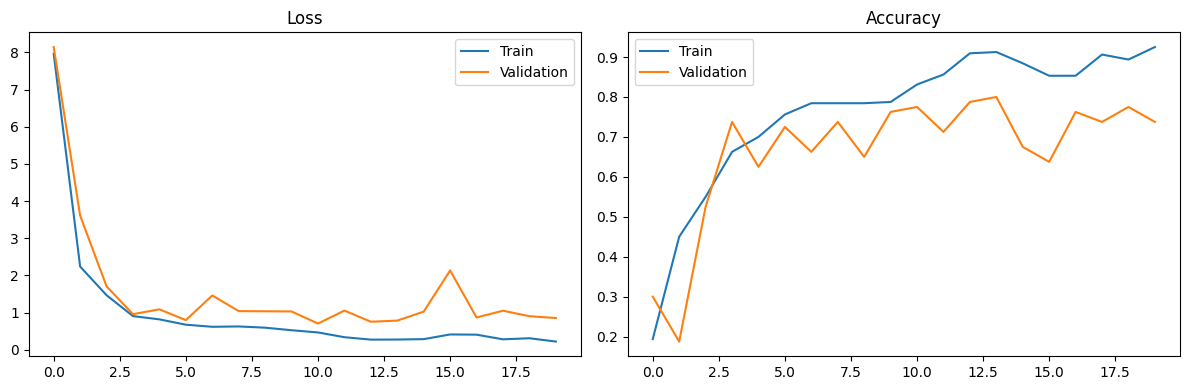

🔊 PREDICTION: sneezing (confidence: 99.95%)
🎤 Processing audio...
🔊 PREDICTION: dog (confidence: 88.53%)
🎤 Processing audio...
🔊 PREDICTION: clock_tick (confidence: 99.06%)
🎤 Processing audio...
🔊 PREDICTION: crying_baby (confidence: 91.75%)
🎤 Processing audio...
🔊 PREDICTION: crying_baby (confidence: 97.91%)
🎤 Processing audio...
🔊 PREDICTION: crying_baby (confidence: 99.60%)
🎤 Processing audio...
🔊 PREDICTION: crackling_fire (confidence: 79.10%)
🎤 Processing audio...
🔊 PREDICTION: chainsaw (confidence: 50.46%)
🎤 Processing audio...
🔊 PREDICTION: chainsaw (confidence: 57.16%)
🎤 Processing audio...
🔊 PREDICTION: rain (confidence: 81.62%)
🎤 Processing audio...
🔊 PREDICTION: crying_baby (confidence: 75.22%)
🎤 Processing audio...
🔊 PREDICTION: chainsaw (confidence: 35.12%)
🎤 Processing audio...
🔊 PREDICTION: chainsaw (confidence: 66.89%)
🎤 Processing audio...
🔊 PREDICTION: sneezing (confidence: 99.75%)


In [20]:
%%javascript
const setup_recording = () => {
  const div_id = 'audio_recording';
  const button_id = 'record_button';
  const output_id = 'output_text';
  const audio_id = 'recorded_audio';
  const audio_placeholder_id = 'audio_placeholder';
  const download_link_id = 'download_link';

  const div = document.createElement('div');
  div.id = div_id;
  div.style.display = 'flex';
  div.style.alignItems = 'center';
  div.style.justifyContent = 'center';

  const record_button = document.createElement('button');
  record_button.id = button_id;
  record_button.textContent = 'Record';
  record_button.style.fontSize = '1.2em';
  record_button.style.padding = '10px 20px';
  record_button.style.marginRight = '10px';
  record_button.style.backgroundColor = '#4CAF50';
  record_button.style.color = 'white';
  record_button.style.border = 'none';
  record_button.style.borderRadius = '5px';
  record_button.style.cursor = 'pointer';

  const output_text = document.createElement('div');
  output_text.id = output_id;
  output_text.textContent = 'Recording status: Idle';
  output_text.style.fontSize = '1.2em';

  div.appendChild(record_button);
  div.appendChild(output_text);
  google.colab.output.setIframeHeight(div.clientHeight + 50);

  const audio_placeholder = document.createElement('div');
  audio_placeholder.id = audio_placeholder_id;
  div.appendChild(audio_placeholder);

  let mediaRecorder;
  let audioChunks = [];
  let recording_started = false;

  record_button.onclick = () => {
    if (!recording_started) {
      navigator.mediaDevices.getUserMedia({ audio: true })
        .then(stream => {
          mediaRecorder = new MediaRecorder(stream);
          audioChunks = [];

          mediaRecorder.ondataavailable = event => {
            audioChunks.push(event.data);
          };

          mediaRecorder.onstop = () => {
            const audioBlob = new Blob(audioChunks, { type: 'audio/wav' });
            const audioUrl = URL.createObjectURL(audioBlob);

            const audio = document.createElement('audio');
            audio.id = audio_id;
            audio.controls = true;
            audio.src = audioUrl;

            const download_link = document.createElement('a');
            download_link.id = download_link_id;
            download_link.href = audioUrl;
            download_link.download = 'recorded_audio.wav';
            download_link.textContent = 'Download WAV';
            download_link.style.marginLeft = '10px';
            download_link.style.textDecoration = 'none';
            download_link.style.color = '#007BFF';

            audio_placeholder.innerHTML = ''; // Clear previous audio
            audio_placeholder.appendChild(audio);
            audio_placeholder.appendChild(download_link);

            // Read the Blob as ArrayBuffer and then as base64
            const reader = new FileReader();
            reader.onloadend = () => {
              const base64data = reader.result.split(',')[1];
              google.colab.kernel.invokeFunction('notebook.run', [base64data]);
            };
            reader.readAsDataURL(audioBlob);

            record_button.textContent = 'Record';
            output_text.textContent = 'Recording status: Idle';
            recording_started = false;
          };

          mediaRecorder.start();
          recording_started = true;
          record_button.textContent = 'Stop Recording';
          output_text.textContent = 'Recording status: Recording...';
        })
        .catch(err => {
          console.error('Error accessing microphone:', err);
          output_text.textContent = 'Recording status: Error - could not access microphone.';
        });
    } else {
      mediaRecorder.stop();
    }
  };

  return div;
};

const output = setup_recording();
document.querySelector('#output-area').appendChild(output);